# Detecting Duplicates
In the previous EDA step, we found signs of numerous duplicated tweets. Some of the text strings are exactly identical. These can be dropped using Pandas `drop_duplicates` method. Others are more difficult. Some contain different hashtags and handles. Others have slightly different punctuation.

In this notebook, we'll detect duplicates by measuring the similarity between strings. The basic approach is to clean the text (removing punctuation, stopwords, hashtags and handles), vectorize each string using a word count vectorizer, and measure the cosine angle between vectors. Pairs of sentences with the smallest cosine angle are good candidates for being duplicates.

In [1]:
import pandas as pd
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import numpy as np

stopwords = stopwords.words('english')

Restore the session variables from the DataWranglingEDA step.

In [2]:
import dill
dill.load_session('../session/DataWrangling_EDA.db')

Clean the text to remove punctuation and stopwords

In [3]:
def clean_string(text):
    text = ''.join([character for character in text if character not in string.punctuation])
    text = text.lower()
    text = ' '.join([word for word in text.split() if word not in stopwords])
    return text

Prepare a CountVectorizer using the vocabulary of the training set. `vectors` is a vectorized version of the text of each tweet.

In [4]:
vectorizer = CountVectorizer()
vectors = vectorizer.fit_transform(list(map(clean_string, train.text))).toarray()

Let's compare all of the training tweet vectors to the one already identified as having duplicates by computing the cosine similarity to this string.

In [5]:
test_string = 'Twelve feared killed in Pakistani air ambulance helicopter crash'
test_vec = vectorizer.transform(list(map(clean_string,pd.Series(test_string)))).toarray()
csim = cosine_similarity(test_vec, vectors)

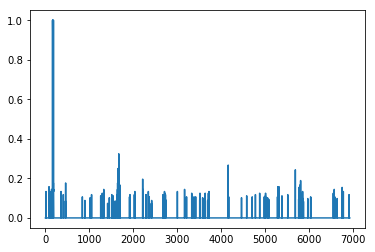

In [6]:
hits = np.amax(csim,0)
plt.plot(hits)

This graph shows that there are a lot of tweets that have non-zero similarity, but the threshold remains low. Let's look at some examples where the threshold is above 0.5.

In [7]:
train.text.iloc[np.greater(hits,0.5)]

172     Twelve feared killed in Pakistani air ambulan...
174    Twelve feared killed in Pakistani air ambulanc...
177    Twelve feared killed in Pakistani air ambulanc...
182     Twelve feared killed in Pakistani air ambulan...
187    Pakistan air ambulance helicopter crash kills ...
203    Twelve feared killed in Pakistani air ambulanc...
Name: text, dtype: object

All of the items with the exception of 175 seem to begin identically to the test string. 175 looks a bit different. Let's have a close look at the entire string.

In [8]:
print(test_string)
print(train.text.iloc[175])

Twelve feared killed in Pakistani air ambulance helicopter crash
Pakistan air ambulance helicopter crash kills nine 


This is an unlikely candidate for a duplicate. It's about a crash that kills nine, not twelve. What's it's cosine similarity score?

In [9]:
hits[175]

0.5345224838248487

This value is just above our threshold of 0.5. Maybe we should select a higher number for the similarity threshold? Let's look at tweets with lower, but non-zero, similarity.

In [10]:
train.text.iloc[np.greater(hits,0.1) & np.less(hits,0.5)]

14        Damage to school bus on 80 in multi car crash  
83       Overturns On  Interstate  Click here if you'v...
85      Carolina accident: Motorcyclist Dies in I-540 ...
100     .  police had previously died in a road accide...
148       mbataweel:   Family members who killed in an...
                              ...                        
7403    Officer Wounded Suspect Killed in Exchange of ...
7405      Richmond police officer wounded suspect killed 
7408    California cops have sketch of gunman who kill...
7433     Officer Wounded Suspect Killed in Exchange of...
7588    BREAKING:  claims responsibility for mosque at...
Name: text, Length: 157, dtype: object

These look like they're definitely not duplicates. Interestingly we see indices 10130 and 10136 look like duplicates.

In the next step, we have to compare each tweet with every other. We can compute the cosine similarity between every pair of tweets. The result is a matrix of similarity scores. 

In [11]:
csim = cosine_similarity(vectors, vectors)

Create a set of index values containing suspected duplicates. Do this by iterating through the rows of the `csim` matrix, then iterating through the columns but start at the diagnoal (don't look at values on or below the diagonal). once the set is constructed, the corresponding rows can be dropped from the training set.

This task is complicated by the fact that the order of indices will not be preserved. Ideally, the order would be preserved so that we can examine duplicates side-by-side. 

Let's reason this out a little more. As we iterate through the rows, we want to know only the first row of each duplicate. It's like we want a map of `{ first_duplicate : [all other duplicates] }`. To create this row, we would iterate through rows. But before adding any row to the dictionary, we have to make sure that it's not among values already stored. 

In [12]:
n_rows, n_cols = csim.shape

In [72]:
from collections import defaultdict

duplicates = defaultdict(list)
subsequent_duplicates = list()

threshold = 0.6

for row in range(n_rows):
    if row not in subsequent_duplicates:
        for col in range(row + 1,n_cols):
            if csim[row,col] > threshold:
                duplicates[row].append(col)
                subsequent_duplicates.append(col)

In [73]:
len(duplicates)

481

In [78]:
dup_rows = first_duplicates.keys()


for first_dup in dup_rows:

    print('\n' + train.iloc[first_dup].text)
    for d in duplicates[first_dup]:
        duplicate = train.iloc[d]
        print(duplicate.target, duplicate.text)



I love fruits
0 Love love love do you remember your first crush ? ??

Summer is lovely
0 Summer          

Love skiing
0 Love love love do you remember your first crush ? ??

Love my girlfriend
0 Love love love do you remember your first crush ? ??

 Wholesale Markets ablaze 
1  huge fire at Wholesale markets ablaze 

Check these out:     
0 Disillusioned lead character  Check Happy go lucky free spirit girl Check Dream life crushed Check Great music Check All Crowe tropes intact

How the West was burned: Thousands of wildfires ablaze in California alone 
1 How the West was burned: Thousands of wildfires ablaze in  alone    

I-77 Mile Marker 31 South Mooresville  Iredell Vehicle Accident Ramp Closed at 8/6 1:18 PM
1 I-77 Mile Marker 31 to 40 South Mooresville  Iredell Vehicle Accident Congestion at 8/6 1:18 PM

FYI CAD:FYI: ;ACCIDENT PROPERTY DAMAGE;NHS;999 PINER RD/HORNDALE DR
1 ;ACCIDENT PROPERTY DAMAGE; PINER RD/HORNDALE DR

???? it was an accident 
0  were you marinading it or wa

How is it one careless match can start a forest fire but it takes a whole box to start a campfire?
0 How is it one careless match can start a forest fire but it takes a whole box to start a campfire

Fire in Pisgah National Forest grows to 375 acres 
1 Fire in Pisgah National Forest grows to 375 acres - WSOC Charlotte 

Only you can prevent forest fires. ???? 
0 ' no pharrell  only YOU can prevent forest fires ' ??

 As California fires rage the Forest Service sounds the alarm about rising wildfire costs: _...  
1 As California fires rage Forest Service sounds the alarm about sharply rising wildfire costs  
1 As California fires rage the Forest Service sounds the alarm about rising wildfire costs 

 U.S. Forest Service says spending more than half of budget on fires 
1 CLIMATE CONSEQUENCES: U.S. Forest Service Says Spending More Than Half Of Budget On Fires  
1 U.S. Forest Service says spending more than half of budget on fires 
1 U.S. Forest Service says spending more than half of bud

1 VIDEO: 'We're picking up bodies from water': Rescuers are searching for hundreds of migrants in the Mediterran... 
1 VIDEO: 'We're picking up bodies from water' - Rescuers are searching for hundreds of migrants in the Mediterranean... 
1 VIDEO: 'We're picking up bodies from water': Rescuers are searching for hundreds of migrants in the Mediterranean after a boat carryi...
1   VIDEO: 'We're picking up bodies from water' - BBC News - Home: Rescuers are searching for hundreds of.. 
1  VIDEO: 'We're picking up bodies from water': Rescuers are searching for hundreds_ 
1 VIDEO: 'We're picking up bodies from water': Rescuers are searching for hundreds of migrants in the...   

 Fears over missing migrants in Med: Rescuers search for survivors after a boat carrying as many a...  
1  Fears over missing migrants in Med: Rescuers search for survivors after a boat carrying as ma...  
1 Fears over missing migrants in Med: Rescuers search for survivors after a boat carrying as many as 600 migrant.

OK, this is weird. We have lots of duplicates, but for some reason, they're not showing up together. 

[[1720],
 [5182],
 [1720],
 [1720],
 [64],
 [1772],
 [58],
 [77],
 [88],
 [97, 155],
 [117],
 [1720],
 [131, 138, 139, 143, 150],
 [149],
 [138, 139, 143, 150],
 [137, 145, 146, 151, 153],
 [146, 151, 153],
 [139, 143, 150],
 [143, 150],
 [150],
 [146, 151, 153],
 [151, 153],
 [155],
 [153],
 [159],
 [164, 167, 172, 183],
 [167, 172, 183],
 [172, 183],
 [183],
 [759],
 [4801],
 [205],
 [255, 262, 270],
 [268],
 [262, 270],
 [270],
 [272, 284, 285],
 [284, 285],
 [304],
 [285],
 [289],
 [308],
 [315, 316, 330, 336, 337, 338, 339],
 [315, 316, 317, 324, 326, 331, 333, 337, 339, 342],
 [315, 316, 329, 337, 339],
 [316, 317, 324, 326, 329, 330, 331, 333, 336, 337, 338, 339, 342],
 [317, 324, 326, 329, 330, 331, 333, 336, 337, 338, 339, 342],
 [324, 326, 331, 333, 337, 339, 342],
 [326, 331, 333, 337, 339, 342],
 [331, 333, 337, 339, 342],
 [337, 339],
 [336, 337, 338, 339],
 [333, 337, 339, 342],
 [337, 339, 342],
 [337, 338, 339],
 [338, 339, 342],
 [339],
 [342],
 [353, 360, 366, 368],
 